# OpenStreetMaps (OSM) Model

## Imports

In [1]:
import sys
sys.path.insert(0, '../utils')
import model_utils
import data_utils

import pandas as pd
import numpy as np

import warnings
import logging

warnings.filterwarnings("ignore")
mpl_logger = logging.getLogger('matplotlib')
wandb_logger = logging.getLogger('wandb')
urllib_logger = logging.getLogger('urllib3')
git_logger = logging.getLogger('git')
pil_logger = logging.getLogger('pil')

mpl_logger.setLevel(logging.ERROR)
wandb_logger.setLevel(logging.CRITICAL)
pil_logger.setLevel(logging.CRITICAL)
git_logger.setLevel(logging.ERROR)
urllib_logger.setLevel(logging.ERROR)

import wandb
wandb.init(project="tm-poverty-prediction")

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'

data_dir = '../data/zoom17/'
ntl_summary_stats_file = data_dir+'nightlights_summary_stats.csv'
dhs_indicators_file = data_dir+'dhs_indicators.csv'

osm_roads_file = data_dir+'osm_roads.csv'
osm_buildings_file = data_dir+'osm_buildings.csv'
osm_pois_file = data_dir+'osm_pois.csv'

## Load Datasets

In [3]:
# Load DHS indicators and nighttime lights
dhs_indicators = pd.read_csv(dhs_indicators_file)
ntl_summary_stats = pd.read_csv(ntl_summary_stats_file)

# Load OSM datasets
roads = pd.read_csv(osm_roads_file)
buildings = pd.read_csv(osm_buildings_file)
pois = pd.read_csv(osm_pois_file)

# Define feature columns
road_cols = roads.columns[1:]
building_cols = buildings.columns[1:]
poi_cols = pois.columns[1:]
ntl_cols = ntl_summary_stats.columns[1:]

# Get list of columns
osm_cols = list(road_cols) + list(building_cols) + list(poi_cols)
osm_ntl_cols = list(osm_cols) + list(ntl_cols)

## Combine Features

In [4]:
# Merge roads + buildings + pois
osm = roads.merge(buildings, on='DHSCLUST')
osm = osm.merge(pois, on='DHSCLUST')
print("Shape of osm dataframe: {}".format(osm.shape))

# Merge osm + nightlights
osm_ntl = osm.merge(ntl_summary_stats, on='DHSCLUST')
print("Shape of osm+ntl dataframe: {}".format(osm_ntl.shape))

# merge dhs + osm
dhs = dhs_indicators.merge(osm_ntl, left_on='Cluster number', right_on='DHSCLUST')

Shape of osm dataframe: (1214, 146)
Shape of osm+ntl dataframe: (1214, 154)


## Spearman and Pearsons Correlation

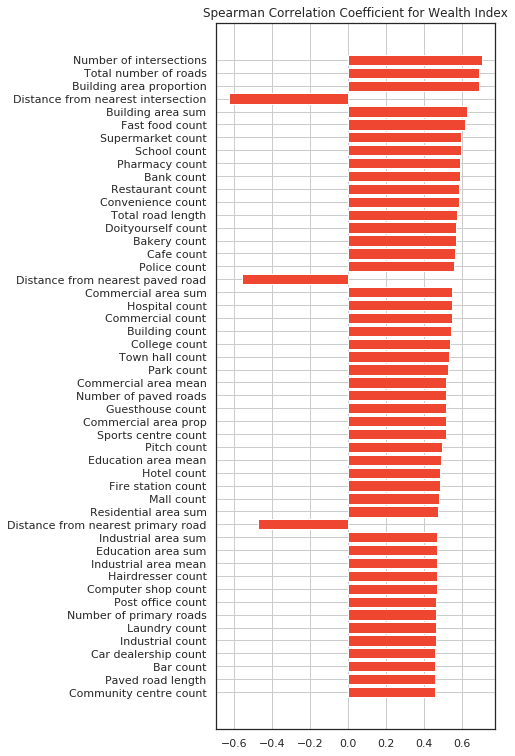

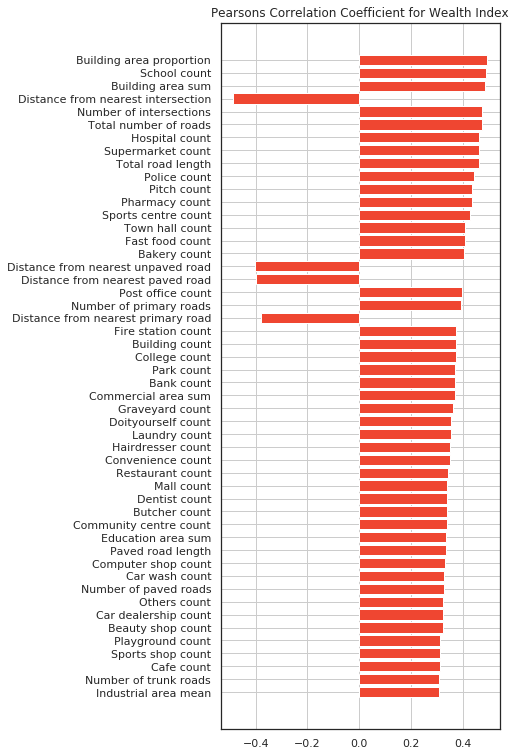

In [5]:
data_utils.plot_corr(
    data=dhs,
    features_cols=osm_cols,
    indicator = 'Wealth Index',
    max_n=50,
    figsize=(5,13)
);

## Machine Learning Pipeline

### Configuration

In [6]:
# Scoring metrics
scoring = {
    'r2': data_utils.pearsonr2,
    'rmse': data_utils.rmse
}

# Indicators of interest
indicators = [
    'Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

## OSM Features + Nighttime Lights

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Socioeconomic indicator: Wealth Index
fit_time : 108.1643
[108.12676311 108.64758229 108.19978261 107.9266243  107.92081046]
score_time : 0.4267
[0.42518306 0.42655015 0.42938042 0.42399287 0.42857456]
test_r2 : 0.6197
[0.59413479 0.64906646 0.62830228 0.63670092 0.59033431]
train_r2 : 0.7795
[0.78225784 0.77685467 0.77970262 0.77847449 0.78006211]
test_rmse : 43860.2800
[45967.60005888 44049.50144154 40413.44814148 44076.68537627
 44794.16487477]
train_rmse : 34245.4102
[33845.71250482 34170.96340654 34775.31164972 34147.76943206
 34287.29415374]


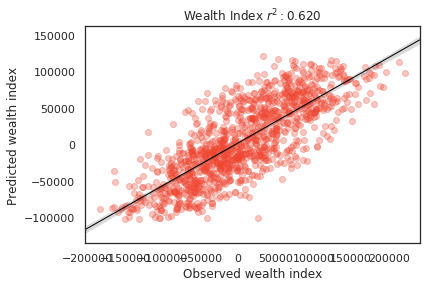

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   10.1s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   15.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.6s finished


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Socioeconomic indicator: Education completed (years)
fit_time : 109.5464
[109.99046564 109.70819497 109.31271482 109.60699296 109.11369276]
score_time : 0.4242
[0.42208791 0.42169738 0.42610645 0.42508435 0.42578316]
test_r2 : 0.4845
[0.4771178  0.48193769 0.4315449  0.5504453  0.48148648]
train_r2 : 0.6918
[0.6920181  0.69245591 0.69943209 0.68622608 0.68897449]
test_rmse : 1.6904
[1.63769357 1.79645452 1.73291577 1.64359941 1.64152338]
train_rmse : 1.3422
[1.35269156 1.32043684 1.33153951 1.34856207 1.35762566]


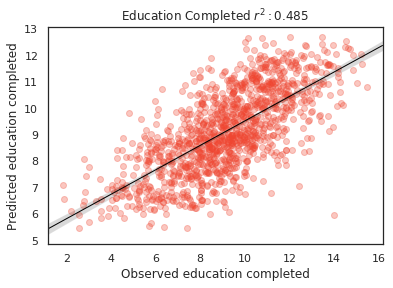

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    9.9s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   14.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.1s finished


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Socioeconomic indicator: Access to electricity
fit_time : 107.7414
[108.14447713 107.64694667 108.37607026 107.14135885 107.39833498]
score_time : 0.5105
[0.62022758 0.42776299 0.64668059 0.43500447 0.42287898]
test_r2 : 0.3452
[0.30725338 0.30871336 0.36345204 0.39099807 0.35538759]
train_r2 : 0.5292
[0.54134164 0.51024881 0.52557187 0.53106451 0.53762967]
test_rmse : 0.1184
[0.10078761 0.11579343 0.12386902 0.13015615 0.1211705 ]
train_rmse : 0.1024
[0.10564016 0.10593213 0.10116947 0.09886263 0.10061654]


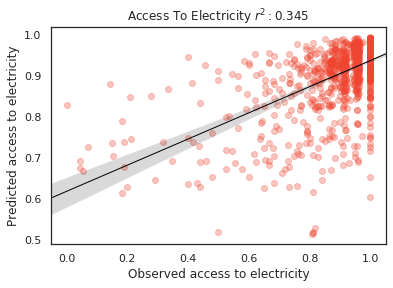

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    7.9s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   12.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.1s finished


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Socioeconomic indicator: Access to water (minutes)
fit_time : 104.1566
[103.62006974 103.36352897 105.06005812 104.53700876 104.20220065]
score_time : 0.7335
[0.99758291 0.96674299 0.52292705 0.42102647 0.75898719]
test_r2 : 0.0556
[0.10947743 0.08746586 0.02091057 0.02451228 0.03571505]
train_r2 : 0.3356
[0.41121929 0.29145579 0.40565679 0.29511274 0.27445021]
test_rmse : 7.9863
[12.65105481  7.97095412  6.69686517  6.0710554   6.54173818]
train_rmse : 6.9597
[5.55819418 7.34699662 7.01387296 7.41263249 7.46703554]


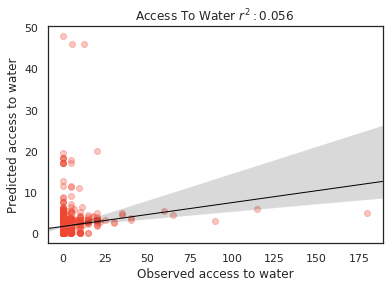

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   10.1s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   14.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=7, max_features='log2',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=969, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


In [7]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=osm_ntl_cols, 
    indicator_cols=indicators,
    wandb=wandb,
    scoring=scoring,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=False,
    verbose=2
)

## OSM Features Only

Socioeconomic indicator: Wealth Index
fit_time : 105.5277
[106.77223349 105.49705267 105.3679924  105.11816096 104.88328815]
score_time : 0.5021
[0.41778731 0.64613843 0.44810605 0.50424743 0.49416161]
test_r2 : 0.5883
[0.59450307 0.60727197 0.58297363 0.60375808 0.55305839]
train_r2 : 0.7540
[0.74768085 0.75299858 0.75574587 0.75640448 0.75729353]
test_rmse : 45630.1195
[45988.90500582 46296.46328057 42870.31857984 46146.38527796
 46848.52525625]
train_rmse : 36217.5609
[36077.73562941 35638.15273756 36884.94820922 36160.35087123
 36326.61687552]


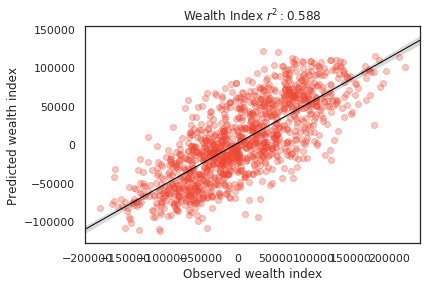

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


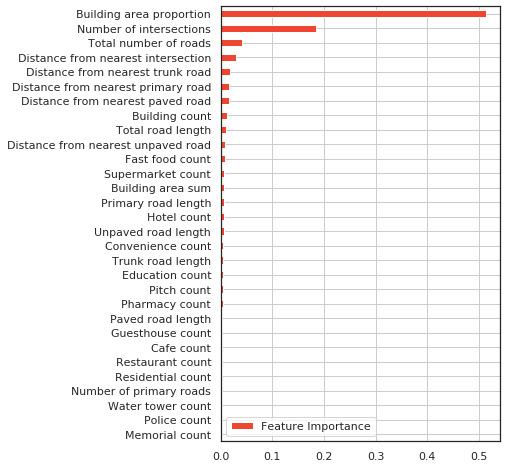

Socioeconomic indicator: Education completed (years)
fit_time : 103.7814
[104.40007448 104.14889026 103.94789457 103.24145341 103.16848254]
score_time : 0.4218
[0.42017031 0.41743827 0.42748451 0.42103267 0.4227376 ]
test_r2 : 0.4636
[0.48220645 0.45854176 0.39959129 0.53052792 0.44691195]
train_r2 : 0.6674
[0.66237725 0.66905462 0.67768631 0.66075018 0.66695038]
test_rmse : 1.7261
[1.63273357 1.83820256 1.78069724 1.68287048 1.69578323]
train_rmse : 1.3999
[1.42205966 1.37652709 1.3841662  1.40636319 1.41021887]


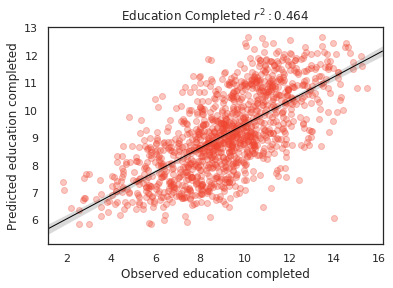

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


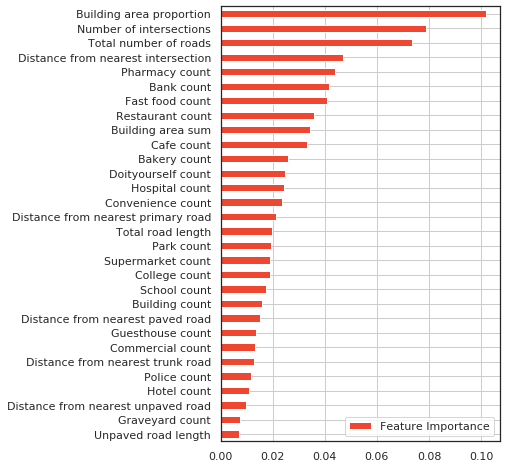

In [ ]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=osm_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

### Road Features

In [ ]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=road_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

## Buildings

In [ ]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=building_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

## Points of Interest

In [ ]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=poi_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)